In [96]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [97]:
df_train = pd.read_csv('train.csv')
y= np.log(df_train['Sale_Price'])

In [98]:
df_train.columns[df_train.isnull().any()]

Index(['Garage_Yr_Blt'], dtype='object')

In [99]:
df_train['Garage_Yr_Blt'] = df_train['Garage_Yr_Blt'].fillna(0)

In [100]:
y = np.log(df_train['Sale_Price'])

In [101]:
df_train = df_train.drop(['PID','Sale_Price'],axis = 1)

In [102]:
features_to_remove = ['Street', 'Utilities', 'Condition_2', 'Roof_Matl', 'Heating', 'Pool_QC', 'Misc_Feature', 'Low_Qual_Fin_SF', 'Pool_Area', 'Longitude','Latitude']

In [103]:
df_train = df_train.drop(features_to_remove,axis = 1)

In [111]:
features_to_winsor = ["Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "BsmtFin_SF_2", "Bsmt_Unf_SF", "Total_Bsmt_SF", "Second_Flr_SF", 'First_Flr_SF', "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF", "Enclosed_Porch", "Three_season_porch", "Screen_Porch", "Misc_Val"]

In [112]:
def revalue_column(x, M):
    if x < M:
        return x
    else:
        return M


percentile = 0.95
Winzorization_M = []

for column in features_to_winsor:
  M = df_train[column].quantile(percentile)
  df_train[column] = df_train[column].apply(lambda x: revalue_column(x, M))
  Winzorization_M.append(M)

In [49]:
Winzorization_M

[104.0,
 16971.5,
 472.0,
 445.0,
 1452.0,
 1756.5,
 1130.0,
 1813.5,
 2466.0,
 852.5,
 324.0,
 179.0,
 174.5,
 0.0,
 168.0,
 0.0]

In [113]:
categorical_features = df_train.select_dtypes(include=['object', 'category'])
numerical_features = df_train.select_dtypes(exclude=['object', 'category'])

In [118]:
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_features.columns)

In [119]:
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoded_categorical_features = encoder.fit_transform(categorical_features)
encoded_categorical_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))

In [120]:
df_encoded = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)

In [121]:
df_encoded.columns

Index(['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'Total_Bsmt_SF', 'First_Flr_SF',
       ...
       'Sale_Type_New', 'Sale_Type_Oth', 'Sale_Type_VWD', 'Sale_Type_WD ',
       'Sale_Condition_Abnorml', 'Sale_Condition_AdjLand',
       'Sale_Condition_Alloca', 'Sale_Condition_Family',
       'Sale_Condition_Normal', 'Sale_Condition_Partial'],
      dtype='object', length=309)

In [146]:
from sklearn.linear_model import ElasticNet

In [160]:
elastic_net = ElasticNet(alpha=0.005, l1_ratio = 0.2,random_state= 0)

In [161]:
elastic_net.fit(df_encoded,y)

ElasticNet(alpha=0.005, l1_ratio=0.2, random_state=0)

In [162]:
y_pred = elastic_net.predict(df_encoded_test)

In [163]:
rmse(y_pred, y_test_log)

0.12748864364177825

In [141]:
from xgboost import XGBRegressor

In [142]:
xgb = XGBRegressor(n_estimators=5000, learning_rate=0.05, max_depth=6, subsample = 0.5, random_state=0)

In [143]:
xgb.fit(df_encoded, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [144]:
y_pred = xgb.predict(df_encoded_test)

In [145]:
rmse(y_pred, y_test_log)

0.11521064825100598

In [125]:
df_test = pd.read_csv('test.csv')
y_test = pd.read_csv('test_y.csv')

In [126]:
y_test_log = np.log(y_test['Sale_Price'])

In [127]:
df_test['Garage_Yr_Blt'] = df_test['Garage_Yr_Blt'].fillna(0)

In [128]:
df_test = df_test.drop(['PID'],axis = 1)

In [129]:
df_test = df_test.drop(features_to_remove,axis = 1)

In [130]:
for column, M in zip(features_to_winsor,Winzorization_M):
  df_test[column] = df_test[column].apply(lambda x: revalue_column(x, M))

In [132]:
categorical_features_test = df_test.select_dtypes(include=['object', 'category'])
numerical_features_test = df_test.select_dtypes(exclude=['object', 'category'])

In [133]:
scaled_numerical_features_test = scaler.transform(numerical_features_test)
scaled_numerical_df_test = pd.DataFrame(scaled_numerical_features_test, columns=numerical_features.columns)

In [134]:
encoded_categorical_features_test = encoder.transform(categorical_features_test)
encoded_categorical_df_test = pd.DataFrame(encoded_categorical_features_test, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))

In [138]:
df_encoded_test = pd.concat([scaled_numerical_df_test, encoded_categorical_df_test], axis=1)

In [149]:
y_pred = elastic_net.predict(df_encoded_test)

In [150]:
def rmse(y, y_pred):
  n = len(y)
  return np.sqrt(sum((y-y_pred)**2) / n)

rmse(y_pred, y_test_log)

0.35515043960755166

In [142]:
df_test_encoded = pd.get_dummies(df_test)

In [143]:
missing_columns = set(X.columns)-set(df_test_encoded.columns)

In [145]:
for column in missing_columns:
  df_test_encoded[column] = 0

In [147]:
X_test = df_test_encoded[X.columns]

In [148]:
y_pred = elastic_net.predict(X_test)

In [151]:
y_test_log = np.log(y_test['Sale_Price'])

In [159]:
y_test_log[0]

11.626254150277232

In [152]:
def rmse(y, y_pred):
  n = len(y)
  return np.sqrt(sum((y-y_pred)**2) / n)

rmse(y_pred, y_test_log)

0.16816170225577526

In [156]:
y_pred - y_test_log

0     -0.059820
1     -0.070267
2     -0.040957
3     -0.173000
4     -0.092588
         ...   
874   -0.131018
875   -0.068497
876   -0.103668
877   -0.021169
878    0.203320
Name: Sale_Price, Length: 879, dtype: float64

In [155]:
y_test_log

0      11.626254
1      11.911702
2      12.083905
3      11.982929
4      11.813030
         ...    
874    12.190959
875    11.986049
876    12.676076
877    11.951180
878    12.007622
Name: Sale_Price, Length: 879, dtype: float64

In [33]:
imbalance_threshold = 0.95  # For example, 95% of the samples belonging to one category

# Iterate through columns to check for imbalance
imbalanced_columns = []
imbalanced_columns_info = []

for column in df_train.columns:
  value_counts = df_train[column].value_counts(normalize=True)
  most_common_category = value_counts.idxmax()
  most_common_category_percentage = value_counts.max()

  if most_common_category_percentage >= imbalance_threshold:
    imbalanced_columns.append(column)
    imbalanced_columns_info.append((column, most_common_category, most_common_category_percentage))

print("Imbalanced columns:")
for col, category, percentage in imbalanced_columns_info:
  print(f"Column '{col}' has {percentage * 100:.2f}% of samples in category '{category}'")

Imbalanced columns:
Column 'Street' has 99.46% of samples in category 'Pave'
Column 'Utilities' has 99.90% of samples in category 'AllPub'
Column 'Land_Slope' has 95.08% of samples in category 'Gtl'
Column 'Condition_2' has 98.73% of samples in category 'Norm'
Column 'Roof_Matl' has 98.54% of samples in category 'CompShg'
Column 'Heating' has 98.54% of samples in category 'GasA'
Column 'Low_Qual_Fin_SF' has 98.59% of samples in category '0'
Column 'Kitchen_AbvGr' has 95.76% of samples in category '1'
Column 'Three_season_porch' has 98.78% of samples in category '0'
Column 'Pool_Area' has 99.66% of samples in category '0'
Column 'Pool_QC' has 99.66% of samples in category 'No_Pool'
Column 'Misc_Feature' has 96.29% of samples in category 'None'
Column 'Misc_Val' has 96.44% of samples in category '0'


In [34]:
df_new = df_train.drop(columns=imbalanced_columns)

In [35]:
df_new.columns

Index(['PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Alley',
       'Lot_Shape', 'Land_Contour', 'Lot_Config', 'Neighborhood',
       'Condition_1', 'Bldg_Type', 'House_Style', 'Overall_Qual',
       'Overall_Cond', 'Year_Built', 'Year_Remod_Add', 'Roof_Style',
       'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Mas_Vnr_Area',
       'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond',
       'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2',
       'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating_QC',
       'Central_Air', 'Electrical', 'First_Flr_SF', 'Second_Flr_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd',
       'Functional', 'Fireplaces', 'Fireplace_Qu', 'Garage_Type',
       'Garage_Yr_Blt', 'Garage_Finish', 'Garage_Cars', 'Garage_Area',
       'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Wood_Deck_SF',
       'Open_P

In [36]:
from scipy.stats import skew

df_new["Sale_Price"] = np.log(df_new["Sale_Price"])

#log transform skewed numeric features:
numeric_feats = df_new.dtypes[df_new.dtypes != "object"].index

skewed_feats = df_new[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df_new[skewed_feats] = np.log1p(df_new[skewed_feats])

In [37]:
df_encoded = pd.get_dummies(df_new)

In [39]:
y = df_encoded['Sale_Price']

In [40]:
X = df_encoded.drop(['Sale_Price','PID'],axis = 1)

In [41]:
train_columns = set(X.columns)

In [75]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [44]:
model_ridge = Ridge()

In [45]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

In [73]:
cv_ridge

0.05     0.139059
0.10     0.137327
0.30     0.133783
1.00     0.130003
3.00     0.127648
5.00     0.127168
10.00    0.127387
15.00    0.128076
30.00    0.130461
50.00    0.133393
75.00    0.136500
dtype: float64

Text(0, 0.5, 'rmse')

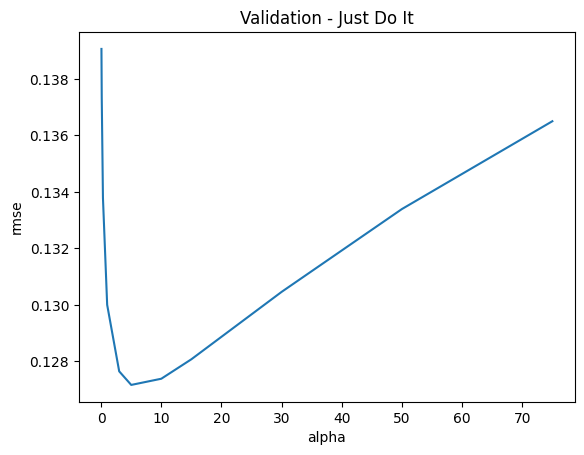

In [46]:
import matplotlib.pyplot as plt

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [47]:
cv_ridge.min()

0.12716763726093866

In [77]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)

In [79]:
y_pred = model_lasso.predict(X_test)

In [81]:
y_test_new

0      11.626254
1      11.911702
2      12.083905
3      11.982929
4      11.813030
         ...    
874    12.190959
875    11.986049
876    12.676076
877    11.951180
878    12.007622
Name: Sale_Price, Length: 879, dtype: float64

In [84]:
np.sqrt(sum((y_pred - y_test_new)**2)/len(y_pred))

0.2917366702819464

In [69]:
rmse_cv(model_lasso)

array([0.14594604, 0.11708004, 0.14004829, 0.12519862, 0.10891928])

In [51]:
df_test.columns[df_test.isnull().any()]

Index(['Garage_Yr_Blt'], dtype='object')

In [53]:
df_test['Garage_Yr_Blt'] = df_test['Garage_Yr_Blt'].fillna(0)

In [54]:
df_test = df_test.drop(columns=imbalanced_columns)

In [55]:
df_test[skewed_feats] = np.log1p(df_test[skewed_feats])

In [56]:
df_test_encoded = pd.get_dummies(df_test)

In [57]:
X_test = df_test.drop(['PID'],axis = 1)

In [58]:
test_columns = set(X_test.columns)

In [61]:
len(test_columns)

68

In [62]:
len(df_train.columns)

83

In [63]:
len(df_test.columns)

69

In [64]:
missing_columns = train_columns - test_columns

In [66]:
for column in missing_columns:
    X_test[column] = 0

<ipython-input-66-8eab85f2b3ab>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
<ipython-input-66-8eab85f2b3ab>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
<ipython-input-66-8eab85f2b3ab>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
<

In [67]:
X_test = X_test[X.columns]

In [72]:
y_test_new = np.log(y_test['Sale_Price'])

In [71]:
y_test_new

0      112000
1      149000
2      177000
3      160000
4      135000
        ...  
874    197000
875    160500
876    320000
877    155000
878    164000
Name: Sale_Price, Length: 879, dtype: int64